<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center>Week 4.  Classification algorithms comparison

Finally, we are going to train classification models, compare several algorithms via cross-validation, and figure out which session's parameters (*session_length* и *window_size*) it is better to use. Also, for the chosen algorithm, we will plot learning curves (which show the dependecy of model performance on the amount of training data) and validation curves (which show the dependency of model performance on one of it's hyperparameters).

**Week 4 roadmap:**
- Part 1. Different algorithms comparison on sessions of 10 websites
- Part 2. Hyperparameter tuning – session_length and window_size
- Part 3. Particular user identification and learning curves

**You might find following links useful:**
   - [Hyperparameter Optimization in Machine Learning Models](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models)
   - [Optimizing your model with cross-validation](http://blog.kaggle.com/2015/06/29/scikit-learn-video-7-optimizing-your-model-with-cross-validation/)

**Your task**
1. Fill in code in provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/10kYgawyf9kId7VDOnBhQ6PH64rU2HR0CmTy5CDwy2Vo)

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.0
IPython 7.1.1

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.20.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.17.14-041714-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : d2fa7c7dfca896055c40b5fea2f513a384ff1fda


In [56]:
from __future__ import division, print_function
# disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

In [2]:
# Change the path to data
PATH_TO_DATA = '../../data/capstone_user_identification/'

## Part 1. Different algorithms comparison on sessions of 10 websites

**Load *X_sparse_10users* and *y_10users* objects serialized earlier, which correspond to 10 users data.**

In [3]:
#You might wanna check the `encoding` param if you face any error while opening the .pkl files..
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**There are more than 14 thousand sessions and almost 5 thousand unique websites.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Split the data into two parts. We are going to use the first part for cross-validation, second part will be used to evaluate performance of the model that we will end up with after cross-validation.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Define cross-validation: 3-fold, with shuffle, random_state=17 – for reproducibility.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Utility function to plot validation curves after running `GridSearchCV` (or `RandomizedCV`).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Train `KNeighborsClassifier` with 100 nearest neighbours (leave other parameters default values, only set `n_jobs = -1` for parallelization) and compare model's mean accuracy during 3-fold cross-validation (for reproducibility use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`.**

**<font color='red'>Question 1. </font> Evaluate KNeighborsClassifier's mean accuracy during cross-validation and model's accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
scores_knn = cross_val_score(knn, X_train, y_train, cv=skf)
knn.fit(X_train, y_train)
print(np.mean(scores_knn), knn.score(X_valid, y_valid))

0.5647188870063362 0.584024650391088


**2. Train a random forest (`RandomForestClassifier`) consisting of 100 trees (for reproducibility use `random_state`=17). Compare model's OOB-score on and its accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

**<font color='red'>Question 2. </font> Evaluate `RandomForestClassifier` Out-of-Bag aka OOB score and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17, oob_score=True)
forest.fit(X_train, y_train)
print(forest.oob_score_, forest.score(X_valid, y_valid))

0.7172322698638488 0.7312159279450107


**3. Train logistic regression with default C value and `random_state`=17. Compare model's mean accuracy during 3-fold cross-validation (don't forget to use `skf` object) on `(X_train, y_train)` and model's accuracy on `(X_valid, y_valid)`. Use `n_jobs = -1` for parallelization.**

In [28]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [77]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
scores_lr = cross_val_score(logit, X_train, y_train, cv=skf)
logit.fit(X_train, y_train)
print(np.mean(scores_lr), logit.score(X_valid, y_valid))

0.7610267543665875 0.7817018250770325


**Read the documentation for [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Logistic regression is well studied and there are algorithms for fast parameter `C` search (faster than using `GridSearchCV`).**

**Using `LogisticRegressionCV` find optimal C value. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `logspace` from `NumPy`. Specify `multi_class`='multinomial' and `random_state`=17 for `LogisticRegressionCV`. For cross-validation use `skf` object created earlier. Use `n_jobs`=-1 for parallelization.**

**Plot validation curves for parameter `C`.**

In [38]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs = logit_c_values1, random_state=17, cv=skf, multi_class='multinomial', n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 10.1 s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [54]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[31], axis=0)

**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [64]:
print(np.max(logit_mean_cv_scores1), logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)])

0.7590968798446474 1.0


**Plot Accuracy vs. `C` dependency graph on cross-validation.**

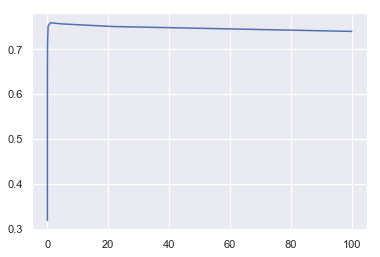

In [57]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Now, do the same again but search `C` values in range `np.linspace`(0.1, 7, 20). Plot the validation curves and find the best accuracy on cross-validation.**

In [65]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, random_state=17, cv=skf, multi_class='multinomial', n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 35 s


**Mean accuracy during cross-validation for each of 10 `C` values.**

In [66]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[31], axis=0)

**Print the best accuracy on cross-validation and corresponding value of C.**

In [67]:
print(np.max(logit_mean_cv_scores2), logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)])

0.7586896943864367 0.4631578947368421


**Plot Accuracy vs. `C` dependency graph on cross-validation.**

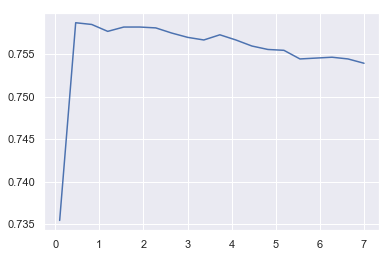

In [68]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

**Print logistic regressoin's accuracy with the best `C` value on `(X_valid, y_valid)`.**

In [71]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7748281583313581

**<font color='red'>Question 3. </font> Evaluate model's mean accuracy for `logit_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [72]:
print(np.max(logit_mean_cv_scores2), logit_cv_acc)

0.7586896943864367 0.7748281583313581


**4. Train SVM (`LinearSVC`) with `C`=1 and `random_state`=17. Compare model's mean accuracy during cross-validation (don't forget to use `skf` object) and model's ccuracy on `(X_valid, y_valid)`.**

In [79]:
from sklearn.svm import LinearSVC

In [80]:
svm = LinearSVC(C=1, random_state=17)
scores_svm = cross_val_score(svm, X_train, y_train, cv=skf)
svm.fit(X_train, y_train)
print(np.mean(scores_svm), svm.score(X_valid, y_valid))

0.7527976723012523 0.7769613652524295


**Using `GridSearchCV` find optimal C value for SVM. Fisrt try wider range: 10 values from 1e-4 up to 1e2 using `linspace` from NumPy. Plot the validation curves.**

In [81]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 21.6 s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [83]:
print(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_)

0.6845153424100793 {'C': 3333.3334000000004}


**Plot Accuracy vs. C dependency graph on cross-validation.**

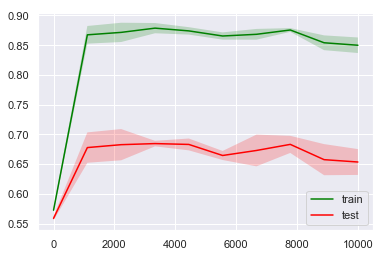

In [84]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**But we remember that using deafault regularization parameter (`C`=1) on cross-validation we get a higher accuracy. That's the case (not rare) of a possibility to make a mistake and searching parameters in a wrong range (the reason is that we took a uniform grid on a large scale and missed optimal interval of `C` values). It is more meaningful to search `C` near 1, in addition, model trains faster than with higher values of `C`.**

**Using `GridSearchCV` find optimal `C` value for SVM in range(1e-3, 1), 30 values, use `linspace` from NumPy. Plt the validation curves.**

In [85]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, n_jobs=-1, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 35.1 s


**Print the best accuracy on cross-validation and corresponding value of `C`.**

In [86]:
print(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_)

0.764681975208291 {'C': 0.10434482758620689}


**Plot Accuracy vs. C dependency graph on cross-validation.**

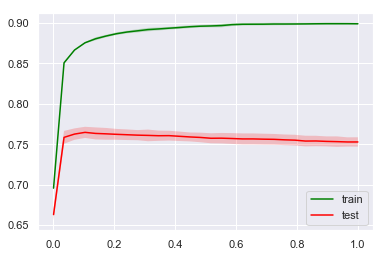

In [87]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

**Print `LinearSVC`'s accuracy with the best `C` value on (X_valid, y_valid).**

In [88]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.7807537331121118

**<font color='red'>Question 4. </font> Evaluate model's mean accuracy for `svm_grid_searcher2` on cross-validation using the best `C` and its accuracy on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [89]:
print(svm_grid_searcher2.best_score_, svm_cv_acc)

0.764681975208291 0.7807537331121118


## Part 2. Parameter tuning – session_length and window_size

**Let's take `LinearSVC` since it performed best on cross-validation in part 1 and check its performance on 8 datasets of 10 users (with different combiantions of `session_length` and `window_size`). Since there are much more computations, we will not search regularization parameter `C` each time.**

**Write the `model_assessment` function with the specification provided below. Pay your attention to all details, e.g. `train_test_split` should be stratified. Don't forget `random_state` anywhere.**

In [92]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, random_state=random_state, stratify=y)
    scores = cross_val_score(estimator, X_train, y_train, cv=cv)
    estimator.fit(X_train, y_train)
    return(np.mean(scores), accuracy_score(y_valid, estimator.predict(X_valid)))

**Double-check that the function is working.**

In [93]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7646853244550981, 0.7807537331121118)

**Apply `model_assessment` function for the best algorithm from the previous part (namely, `svm_grid_searcher2.best_estimator_`) and 9 datasets with different combinations of `session_length` and `window_size` of 10 users. Print `session_length` and `window_size` parameters in the loop as well as an output of the `model_assessment` function.
It's handy if the `model_assessment` function returns execution time as a third output argument. It took 20 sec to execute this code snippet on my laptop. But with 150 users dataset, each iteration takes a couple of minutes.**

Here, for the convinience it worth to create copies of pickle-files `X_sparse_10users.pkl`, `X_sparse_150users.pkl`, `y_10users.pkl` and `y_150users.pkl` adding `s10_w10` to their names, which means session length of 10 and window width of 10.

In [102]:
# Won't work on non-Linux based Machines (Basically it's creating copies of the files)
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10w10.pkl 

In [103]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s'+str(session_length)+'w'+str(window_size)+'.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s'+str(session_length)+'w'+str(window_size)+'.pkl')
        print(session_length, window_size, model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

15 10 (0.8238214955278105, 0.8404835269021095)
10 10 (0.7646853244550981, 0.7807537331121118)
15 7 (0.8479403769844098, 0.8543222166915547)
10 7 (0.7970161463734652, 0.8073668491786958)
7 7 (0.7529891114830342, 0.7617388418782147)
15 5 (0.868001372554347, 0.8752963489805595)
10 5 (0.8159247205318039, 0.8245614035087719)
7 5 (0.774058674563226, 0.7853247984826932)
5 5 (0.7252830650398828, 0.7362494073020389)
Wall time: 29.8 s


**<font color='red'>Question 5. </font> Evaluate `LinearSVC`'s accuracy  with optimal `C` on `X_sparse_10users_s15_w5` dataset. Write model's mean accuracy on cross-validation and its accuracy on validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [105]:
model_assessment(estimator, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s'+str(15)+'w'+str(5)+'.pkl'), 
                 os.path.join(PATH_TO_DATA, 'y_10users_s'+str(15)+'w'+str(5)+'.pkl'), skf)

(0.868001372554347, 0.8752963489805595)

**Comment on the results. Compare mean accuracy on cross-validation and on validation dataset using the following combinations of parameters(`session_length, window_size`): (5,5), (7,7) и (10,10). On average laptop it could take up to an hour. After all, it's data science :)**.

**Make a conclusion about how accuracy depends on session length and window width.**

In [106]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s'+str(session_length)+'w'+str(window_size)+'.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s'+str(session_length)+'w'+str(window_size)+'.pkl')
    print(session_length, window_size, model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

5 5 (0.40858659509908596, 0.42171606560568453)
7 7 (0.43638649409423974, 0.45295840855673264)
10 10 (0.4612588999427913, 0.4836276942538802)
Wall time: 17min 5s


**<font color='red'>Question 6. </font> Evaluate `LinearSVC`'s accuracy with optimal `C` value on `X_sparse_150users`. Write model's accuracy on cross-validation and on the validation dataset. Round your answers up to the third digit after a decimal point. Write your answers with a space between them.**

In [107]:
model_assessment(estimator, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 
                 os.path.join(PATH_TO_DATA, 'y_150users.pkl'), skf)

(0.4612588999427913, 0.4836276942538802)

## Part 3. Particular user identification and learning curves

**Since it may dissapoint that accuracy at multiclass classification problem on 150 users dataset is low, let's joy the fact that some particular user could be identified quite well.**

**Load `X_sparse_150users` and `y_150users` objects serialized earlier which correspond to 150 users dataset with parameters (*session_length, window_size*) = (10,10). Split them into two parts: 70% train data and 30% validation data.**

In [108]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [109]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Train `LogisticRegressionCV` with single `C` value (take the best `C` value on cross-validation in part 1, use an accurate value, not an approximate one). Now we are going to solve 150 tasks One-vs-All, hence set `multi_class`='ovr'. As usual, set `n_jobs=-1` and `random_state`=17 where it is possible (this training might take up to 20 min).**

In [113]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]], cv=skf, n_jobs=-1, random_state=17, multi_class='ovr')
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 4min 32s


**Compare mean accuracy on cross-validation for each user identification problem separately.**

In [142]:
cv_scores_by_user = {user_id: np.mean(scores) for (user_id, scores) in logit_cv_150users.scores_.items()}

In [118]:
cv_scores_by_user = {user_id: np.mean(scores) for (user_id, scores) in logit_cv_150users.scores_.items()}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 6, CV score: 0.9958396485310578
User 13, CV score: 0.996236159606072
User 15, CV score: 0.9951414156621485
User 16, CV score: 0.9917629636028263
User 28, CV score: 0.990032646749408
User 31, CV score: 0.9945992933895361
User 33, CV score: 0.9936295923347456
User 39, CV score: 0.9857474441964414
User 46, CV score: 0.9979773735144889
User 49, CV score: 0.9949328849394247
User 50, CV score: 0.9944847392709221
User 53, CV score: 0.9936087227963695
User 65, CV score: 0.9969973347781819
User 66, CV score: 0.9949640742212859
User 82, CV score: 0.9963612639936241
User 85, CV score: 0.9963196987839488
User 89, CV score: 0.9905122649916512
User 92, CV score: 0.9943596252032839
User 100, CV score: 0.9947138940123931
User 102, CV score: 0.991190153815365
User 103, CV score: 0.9798259124963927
User 105, CV score: 0.9968201105460203
User 106, CV score: 0.9945051894225921
User 118, CV score: 0.9906581115547454
User 119, CV score: 0.9966011573912393
User 120, CV score: 0.9942028893690901
User 126

**Accuracy could seem impressive, but, perhaps, we forget about class disbalance and high accuracy could just be obtained with a constant prediction.  Evaluate the difference between accuracy on cross-validation (we've just evaluated using `LogisticRegressionCV`) and the fraction of labels which differ from user_id (that's the accuracy we get if classificator always says that it is not the $i$-th user in classification task $i$-vs-All) for each user in `y_train_150`.**

In [147]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - (class_distr[user_id] / np.sum(class_distr)))

In [148]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Question 7. </font> Evaluate the fraction of users where `LogisticRegressionCV` performs better than just a constant prediction. Round your answer up to the third digit after the decimal point.**

In [152]:
num_better_than_default / len(np.unique(y_train_150))

0.9066666666666666

**Next step is to plot learning curves for a particular user, let's say for 128-th. Make a new binary vector using `y_150users`, its values are 1 or 0 depending on whether user_id=128 or not.**

In [ ]:
y_binary_128 = ''' YOUR CODE IS HERE '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Evaluate accuracy on cross-validation at "user128-vs-All" task depending on train size. It would be useful to check the documentation for `learning_curve`.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' YOUR CODE IS HERE '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Make a conclusion whether new data helps to improve the model's accuracy with the same problem definition.**

Next week, we will recall linear models trained with stochastic gradient descend, and enjoy how faster they work.